## Instalando a biblioteca Transformers

---



In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install transformers==3

## Importações

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from collections import defaultdict 
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup # bertimbau
from sklearn.metrics import classification_report
from IPython.display import Image

## Carregando o modelo e o tokenizador

In [11]:
pre_trained_model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(pre_trained_model_name)
model = AutoModel.from_pretrained(pre_trained_model_name)

In [12]:
#Classe de manipulação de dataset:
class Dataset(Dataset):

    #Construtor da classe:
    def __init__(self, sentences, labels, tokenizer, max_length):
        #Armazene as entradas que serão passadas ao modelo:
        self.sentences = sentences
        
        #Armazene as labels que serão utilizadas para treino/validação/teste:
        self.labels = labels
        
        #Armazene o tokenizador:
        self.tokenizer = tokenizer
        
        #Armazene o tamanho máximo das sentenças:
        self.max_length = max_length
    
    #Retorna o número de instâncias:
    def __len__(self):
        return len(self.sentences)
    
    #Retorna uma instância completa com base num índice:
    def __getitem__(self, index):
        #Obtenha a entrada do índice pertinente:
        sentence = self.sentences[index]
        
        #Obtenha a label do índice pertinente:
        label = self.labels[index]
        
        #Tokenize a entrada:
        encoding = self.tokenizer.encode_plus(
          sentence,
          add_special_tokens=True,
          max_length=self.max_length,
          return_token_type_ids=True,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt', # pytorch
          truncation=True
        )
    
        #Obtenha os códigos numéricos da sentença:
        input_ids = encoding['input_ids'].flatten()
        
        #Obtenha os códigos numéricos dos token types:
        token_type_ids = encoding['token_type_ids'].flatten()
        
        #Obtenha a máscara de atenção da sentença:
        attention_mask = encoding['attention_mask'].flatten()
        
        #Transforme a label da instância em um tensor:
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        #Retorne um dicionário com estes dados:
        return {
          'input_ids': input_ids,
          'token_type_ids': token_type_ids,
          'attention_mask': attention_mask,
          'labels': label_tensor
        }

## Carregando os dados (Corpus)

In [13]:
path = "drive/MyDrive/Colab Notebooks/Topicos/dados"
df = pd.read_csv(path + '/irregularidades_valid.csv')
print(df.head())

                                                text  helpfulness
0  queixa referente item deg retificacao edital c...            6
1  pratica nepotismo prefeito municipal marcos pa...            5
2  controladora geral municipio castelo piaui sen...            4
3  senhora katia pereira professora manoel emidio...            2
4  dados licitacao orgao publico p m guaribas pro...            1


In [14]:
# Pegando as sentenças e rótulos
sentences = df['text'].values
labels = df['helpfulness'].values

print('Primeira sentença: ', sentences[0])
print('Primeira etiqueta: ', labels[0])

Primeira sentença:  queixa referente item deg retificacao edital concurso alepi consoante dispositivo alem vagas fixadas quadro vagas constante item deste edital sera classificado candidato cada area atuacao exceto area biblioteconomia cargos consultor legislativo assessor tecnico legislativo compor cadastro reserva notadamente item fere principios concurso publico moralidade administrativa pois alem vagas imediatas referidos cargos cadastro reserva composto so pessoa denuncio item cadastro reserva ampliado numero justo modo atenda anseios administracao alepi sociedade principios constitucionais especialmente moralidade alem disso nao ha razoabilidade edital concurso publico cujo prazo validade anos estabelecer apenas so pessoa cadastro reserva solicito orgao fiscalizador investigue item obscuro edital alepi referente concurso presente ano ademais manifesto agradecimento atuacao deste orgao referido concurso
Primeira etiqueta:  6


In [15]:
# Dataset para testar
dtoy = Dataset(sentences, labels, tokenizer, max_length=50)
data_inst = next(iter(dtoy))

print('Input IDs: ', data_inst['input_ids'])
print('Token Type IDs: ', data_inst['token_type_ids'])
print('Attention Mask: ', data_inst['attention_mask'])
print('Labels: ', data_inst['labels'])

Input IDs:  tensor([  101,   179,  1445, 15762, 18685,   125, 22293,  2582,  1282,   304,
        22280,   902,  1013,  5826,  1202,  6720, 14325,   175,  8985,  1202,
        22287, 10398, 11333,   591,  5634, 10398,  4060, 18685,  2166,   902,
         1013,   333, 22278,  8835,  4931,  1078, 12346, 22278,  6475,   304,
        22280,  7601, 12346, 22278, 12527, 22219,  4322,  7744, 17835,   102])
Token Type IDs:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])
Attention Mask:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])
Labels:  tensor(6)


In [16]:
# Dataloader
dltoy = DataLoader(dtoy, batch_size=3)
batch = next(iter(dltoy))

print("Input IDs: ", batch['input_ids'])
print("Token Type IDs: ", batch['token_type_ids'])
print("Attention Mask: ", batch['attention_mask'])
print("Labels: ", batch['labels'])

Input IDs:  tensor([[  101,   179,  1445, 15762, 18685,   125, 22293,  2582,  1282,   304,
         22280,   902,  1013,  5826,  1202,  6720, 14325,   175,  8985,  1202,
         22287, 10398, 11333,   591,  5634, 10398,  4060, 18685,  2166,   902,
          1013,   333, 22278,  8835,  4931,  1078, 12346, 22278,  6475,   304,
         22280,  7601, 12346, 22278, 12527, 22219,  4322,  7744, 17835,   102],
        [  101,  8230,   872,  8735,   714,  4125,  4858, 10567, 22281, 18369,
          2510,  8060,   181, 21672,   143,  4583,   906,  3897, 22281,  8448,
         10034,  7744,   652,  4721, 22280, 10659,   210,  7744, 11098,  1408,
          9057,  1103,   559,   247, 10567, 22281, 18369, 13779,  9319,   236,
          1016, 11691,   304, 22280,   872,  8735,   714, 21195,  7744,   102],
        [  101, 14919,   124,  1250,  1103,   559,   247,  5001, 13779,  1382,
         22283, 17704,   856,  7595, 18953, 13381, 11801, 22232, 22278,   331,
          4335,  3673,  8990,   430, 2

## Criando o modelo

In [17]:
#Classificador de toxidade:
class ToxicClassifier(torch.nn.Module):

    #Construtor da classe
    def __init__(self, n_classes, pre_trained_model_name):
    
        #Inicialize o modelo:
        super(ToxicClassifier, self).__init__()
        
        #Carregue um modelo BERT pré-treinado:
        self.bert = AutoModel.from_pretrained(pre_trained_model_name)
        # self.dropout = torch.nn.Dropout(0.25)
        #Crie a camada linear final para classificação:
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, n_classes)

    #Função de execução do modelo:
    def forward(self, input_ids, attention_mask):
        #Passe a entrada pelo modelo BERT:
        word_outputs, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        return self.linear(pooled_output)

## Treinando o modelo

In [18]:
def training(model, data_loader, loss_fn, optimizer, scheduler, n_examples):
    #Coloque o modelo em modo de treinamento:
    model = model.train()
    
    #Inicialize o erro total da epoch:
    total_loss = 0 
    losses = []
    correct_predictions = 0
    total_preds = []
    
    #Para cada batch do data_loader, faça:
    for batch in data_loader:
        #Obtenha os dados da batch:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        #Passe os dados pelo modelo:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        #Obtenha as predições:
        _, preds = torch.max(outputs, dim=1)
        total_preds.extend([p.item() for p in preds])
        correct_predictions += torch.sum(preds == labels)
        
        #Calcule o erro:
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
        losses.append(loss.item())
        
        #Propague o erro para o modelo, promovendo aprendizado:
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return total_preds, total_loss, correct_predictions.double() / n_examples, np.mean(losses)

## Avaliando o modelo

In [19]:
def evaluation(model, data_loader, loss_fn, n_examples):
    #Coloque o modelo em modo de treinamento:
    model = model.eval()
    
    #Inicialize o erro total da epoch:
    total_loss = 0
    losses = []
    correct_predictions = 0
    total_preds = []
    
    #Para cada batch do data_loader, faça:
    with torch.no_grad():
      for batch in data_loader:
          #Obtenha os dados da batch:
          input_ids = batch["input_ids"]
          attention_mask = batch["attention_mask"]
          labels = batch["labels"]
          
          #Passe os dados pelo modelo:
          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          
          #Obtenha as predições:
          _, preds = torch.max(outputs, dim=1)
          total_preds.extend([p.item() for p in preds])
          correct_predictions += torch.sum(preds == labels)
          
          #Calcule o erro:
          loss = loss_fn(outputs, labels)
          total_loss += loss.item()
          losses.append(loss.item())
    return total_preds, total_loss, correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
# Carregar os dados
df = pd.read_csv(path + '/irregularidades_train.csv')
#sentences_tr = df['text'].values[:100]
#labels_tr = df['helpfulness'].values[:100]
sentences_tr = df['text']
labels_tr = df['helpfulness']

df = pd.read_csv(path + '/irregularidades_valid.csv')
sentences_va = df['text']
labels_va = df['helpfulness']

df = pd.read_csv(path + '/irregularidades_test.csv')
sentences_te = df['text']
labels_te = df['helpfulness']

In [21]:
# Parâmetros do modelo
max_length = 128
batch_size = 32
num_workers = 2

#Crie Datasets para os dados:
dtr = Dataset(sentences_tr, labels_tr, tokenizer, max_length)
dva = Dataset(sentences_va, labels_va, tokenizer, max_length)
dte = Dataset(sentences_te, labels_te, tokenizer, max_length)

#Crie DataLoaders para os Datasets:
dltr = DataLoader(dtr, batch_size=batch_size, num_workers=num_workers)
dlva = DataLoader(dva, batch_size=batch_size, num_workers=num_workers)
dlte = DataLoader(dte, batch_size=batch_size, num_workers=num_workers)

In [22]:
#Crie o modelo:
toxic_classifier = ToxicClassifier(n_classes=9, pre_trained_model_name=pre_trained_model_name)

#Crie elementos de treinamento:
epochs = 2
total_steps = len(dltr)*epochs
loss_function = torch.nn.CrossEntropyLoss()
#loss_function = torch.nn.BCELoss()
optimizer = AdamW(toxic_classifier.parameters(), lr=4e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [23]:
# Histórico
history = defaultdict(list)

#Treine o modelo:
for epoch in range(epochs):
    #Treine em dados de treinamento:
    print(f'Treinando o modelo. Epoch: {epoch}')
    preds_tr, total_loss_tr, tr_acc, tr_loss = training(toxic_classifier, dltr, loss_function, optimizer, scheduler, len(sentences_tr))
    
    #Valide em dados de validação:
    print(f'Validando o modelo, Epoch: {epoch}')
    preds_va, total_loss_va, va_acc, va_loss = evaluation(toxic_classifier, dlva, loss_function, len(sentences_va))
    
    #Imprima os erros de treinamento/validação:
    print(f'Erro de treinamento: {total_loss_tr} Erro médio: {tr_loss} Acurácia: {tr_acc}')
    print(f'Erro de validação: {total_loss_va} Erro médio: {va_loss} Acurácia: {va_acc}')

    history['train_acc'].append(tr_acc)
    history['train_loss'].append(tr_loss)
    history['val_acc'].append(va_acc)
    history['val_loss'].append(va_loss)

Treinando o modelo. Epoch: 0
Validando o modelo, Epoch: 0
Erro de treinamento: 11.696597933769226 Erro médio: 1.9494329889615376 Acurácia: 0.36507936507936506
Erro de validação: 3.3940389156341553 Erro médio: 1.6970194578170776 Acurácia: 0.4603174603174603
Treinando o modelo. Epoch: 1
Validando o modelo, Epoch: 1
Erro de treinamento: 9.928598165512085 Erro médio: 1.654766360918681 Acurácia: 0.4603174603174603
Erro de validação: 3.2041462659835815 Erro médio: 1.6020731329917908 Acurácia: 0.4603174603174603


## Visualizando o resultado

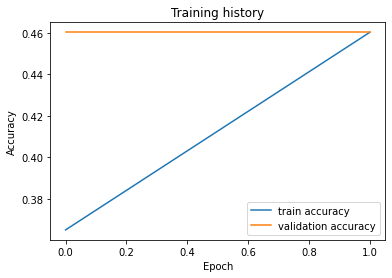

In [24]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

## Testando o modelo

In [25]:
#Teste o modelo:
preds_te, total_loss_te, te_acc, te_loss = evaluation(toxic_classifier, dlte, loss_function, len(sentences_te))

# Relatório
print(classification_report(labels_te, preds_te))


              precision    recall  f1-score   support

           1       0.47      1.00      0.64        30
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         3

    accuracy                           0.47        64
   macro avg       0.06      0.12      0.08        64
weighted avg       0.22      0.47      0.30        64



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
#text = 'queria que desem um olhada neste edital pois estão pedindo documentos que tira o direito de outras empresas participarem'
text = 'os professores estão com dois messes de salário atrasado os dias de julho servidores com messes'
encoded_text = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=35,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt', # pytorch
    truncation=True
)


output = toxic_classifier(input_ids=encoded_text['input_ids'], attention_mask=encoded_text['attention_mask'])
_, prediction = torch.max(output, dim=1)

print(prediction)


tensor([1])
